In [23]:
import requests
from bs4 import BeautifulSoup
# !pip install pycountry
import pycountry
import pandas as pd
import numpy as np
import json

In [24]:
import matplotlib.pyplot as plt
from matplotlib import *
import seaborn as sns

In [25]:
# !pip install matplotlib-venn

In [26]:
# !pip install upsetplot

In [27]:
# from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

In [37]:
# util method
countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3

# Popularity-weighted blocking metric.

Our goal here is to produce a *directed* measure of country-to-country website blocking.

To illustrate our point,
here's a thought experiment: if a Norwegian goes to Indonesia, would they
actually notice that anything is blocked? If Indonesia blocks mostly Indonesian-language content, perhaps not. What if an American goes to China? Since China blocks most popular US websites, they probably will!

We measure this X-to-Y country-to-country comparison here. Our initial goal, upon starting, is to suss out international conflict points.

We'll do this measurement by finding the most *popular* websites in each country, according to Alexa.
Then, for each country, we see which other countries block those popular sites. The intuition here is that blocking Wikipedia is a bigger deal than blocking some tiny political website, since the former is more popular (i.e., widely-visited) than the latter.

# Data collection

If you don't want to replicate our data, **skip down to Data analysis**.

## Website blocking data
You'll need to [download iclab-clean-fortiguard.csv here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48).

Alternatively, if you want to produce this file yourself (i.e., to replicate our work), just run `bloging-pattern-similarity-metric.ipynb` in this repository.


In [28]:
iclabClean1 = pd.read_csv('../data/iclab_cleaned_data/iclab-cleaned-fortiguard.csv')

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Alexa data

In [29]:
def top_sites_in (country_code):
    """
    Finds the top Alex sites by Alexa ranking in a given country.
    Parameter:
        country_code - country whose top sites we are finding based on Alexa ratings
    Returns:
        List of Top Websites in the country 
    """
    
    def process_row (tds):
        rank = int(tds[0].get_text())
        url = tds[1].find('a').get_text('siteinfo').lower()
        daily_time =  tds[2].get_text()
        daily_pageviews_per_visitor =  float(tds[3].get_text())
        perc_traffic_from_search =  float(tds[4].get_text().replace('%', ''))/100
        total_sites_linking_in =  int(tds[5].get_text().replace(',', ''))
        return [rank, url, daily_time, daily_pageviews_per_visitor, perc_traffic_from_search, total_sites_linking_in]
    
    # Scraping Top Sites list from Alexa for country 
    url = "https://www.alexa.com/topsites/countries/" + country_code
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    divs = soup.find_all('div', class_='tr site-listing')
    
    rankings = []
    for div in divs:
        tds = div.find_all('div', class_='td')
        rankings.append(process_row(tds))
    return pd.DataFrame(
        rankings,
        columns = [
            'rank',
            'url',
            'daily_time_on_site_per_visitor',
            'daily_pageviews_per_visitor',
            'perc_traffic_from_search',
            'total_sites_linking_in'
        ])

top_sites_in('US')

,rank,url,daily_time_on_site_per_visitor,daily_pageviews_per_visitor,perc_traffic_from_search,total_sites_linking_in
0,1,google.com,15:43,17.09,0.004,1300441
1,2,youtube.com,16:54,9.68,0.149,988820
2,3,amazon.com,10:26,9.73,0.195,363277
3,4,yahoo.com,5:02,4.65,0.081,319186
4,5,facebook.com,18:52,8.83,0.088,2181031
5,6,zoom.us,8:29,3.94,0.127,3009
6,7,reddit.com,5:33,4.38,0.320,163041
7,8,wikipedia.org,3:47,3.04,0.740,763999
8,9,myshopify.com,22:17,14.47,0.030,118
9,10,ebay.com,10:10,8.04,0.164,74970


## Compute metric

In [30]:
def blocked_sites_in (country_code: str) -> set:
    """
    Finds list of unique Blocked websites in a country
    Parameter:
          Country Code
    Returns:
          Set of Blocked Websites in the Country
    """
    
    # Country Specific blocked sites list
    CC_blocked_list = iclabClean1[(iclabClean1['country']==country_code)&(iclabClean1['censored_updated']==True)]['site'].tolist()
    CC_blocked_set = set(CC_blocked_list) # set of blocked sites in the country
    # HACK: manually remove blocked websites in countries known to block nothing
    if country_code in ['US', 'CA']:
        return set([])
    # HACK: manually add websites known to be blocked in CN
    # https://en.wikipedia.org/wiki/List_of_websites_blocked_in_mainland_China
    if country_code=='CN':
        CC_blocked_set = CC_blocked_set.union(set([
            'google.com',
            'youtube.com',
            'byte.co',
            'facebook.com',
            'webtoons.com',
            'crunchyroll.com',
            'wikipedia.org',
            'live.com',
            'netflix.com',
            'blogspot.com',
            'yahoo.co.jp',
            'bing.com',
            'twitch.tv',
            'twitter.com',
            'tumblr.com',
            'pinterest.com',
            'amazon.co.jp',
            'pornhub.com',
            'wionews.com',
            'imgur.com',
            'nytimes.com',
            'archive.org',
            'nbc.com',
            'hbo.com',
        ]))
    
    return CC_blocked_set

blocked_sites_in('CN')

{'163.com',
 '17ok.com',
 '1905.com',
 '360.cn',
 '39.net',
 '3dmgame.com',
 'address.com',
 'allegro.pl',
 'amazon.co.jp',
 'anonymouse.org',
 'archive.org',
 'bing.com',
 'bittornado.com',
 'blogspot.com',
 'byte.co',
 'cameolingerieonline.com',
 'cctv.com',
 'cefc.org',
 'chinaz.com',
 'crunchyroll.com',
 'douyu.com',
 'facebook.com',
 'fanpage.gr',
 'globalvoicesonline.org',
 'google.com',
 'guildwars.com',
 'hbo.com',
 'hgtv.com',
 'hrcr.org',
 'imgur.com',
 'implantinfo.com',
 'indeed.com',
 'instagram.com',
 'jalb.de',
 'kdnet.net',
 'lanacion.com.ar',
 'lineriderfun.com',
 'live.com',
 'nbc.com',
 'netflix.com',
 'nytimes.com',
 'office.com',
 'ohmynews.com',
 'oovoo.com',
 'paypal.com',
 'people.com.cn',
 'pinterest.com',
 'pornhub.com',
 'rarbg.to',
 'rim.net',
 'schwarzreport.org',
 'sectsco.org',
 'sourceforge.net',
 'southwest.com',
 'sozcu.com.tr',
 'tumblr.com',
 'twitch.tv',
 'twitter.com',
 'webtoons.com',
 'weebly.com',
 'whitepages.com',
 'wikipedia.org',
 'wikiwiki.

In [31]:
from time import sleep

# cache for our top websites
# removes need for duplicate queries
top_sites_cache = {}

# cache for sites blocked in particular country
# removes costly df queries
blocked_sites_cache = {}

def blocked_top_sites (countryA: str, countryB: str, sleep_time=0.5) -> pd.DataFrame:
    '''
    If a person from Country A goes to Country B, what will be blocked?
    
    Phrased differently, which of country A's top sites are blocked in country B?
    
    Takes:
    - CountryA country code
    - Country B country code
    
    Returns:
    - DataFrame of top sites in country A that are blocked in country B.
    '''
    if countryA in top_sites_cache:
        top = top_sites_cache[countryA]
    else:
        # wait a second to prevent 500
        print('Querying Alexa.com')
        sleep(sleep_time)
        top = top_sites_in(countryA)
        top_sites_cache[countryA] = top
    if countryB in blocked_sites_cache:
        blocked = blocked_sites_cache[countryB]
    else:
        blocked = blocked_sites_in(countryB)
        blocked_sites_cache[countryB] = blocked
    return top[top['url'].isin(blocked)]

blocked_top_sites('US', 'CN')

Querying Alexa.com


,rank,url,daily_time_on_site_per_visitor,daily_pageviews_per_visitor,perc_traffic_from_search,total_sites_linking_in
0,1,google.com,15:43,17.09,0.004,1300441
1,2,youtube.com,16:54,9.68,0.149,988820
4,5,facebook.com,18:52,8.83,0.088,2181031
7,8,wikipedia.org,3:47,3.04,0.740,763999
10,11,office.com,9:50,9.34,0.072,5767
11,12,netflix.com,4:20,3.20,0.096,10865
12,13,bing.com,2:52,2.61,0.062,41693
14,15,live.com,5:23,5.33,0.103,43223
18,19,twitch.tv,6:54,3.53,0.070,9771
20,21,instagram.com,8:47,9.71,0.138,622099


In [32]:
blocked_top_sites('US', 'CN')

,rank,url,daily_time_on_site_per_visitor,daily_pageviews_per_visitor,perc_traffic_from_search,total_sites_linking_in
0,1,google.com,15:43,17.09,0.004,1300441
1,2,youtube.com,16:54,9.68,0.149,988820
4,5,facebook.com,18:52,8.83,0.088,2181031
7,8,wikipedia.org,3:47,3.04,0.740,763999
10,11,office.com,9:50,9.34,0.072,5767
11,12,netflix.com,4:20,3.20,0.096,10865
12,13,bing.com,2:52,2.61,0.062,41693
14,15,live.com,5:23,5.33,0.103,43223
18,19,twitch.tv,6:54,3.53,0.070,9771
20,21,instagram.com,8:47,9.71,0.138,622099


In [33]:
# TODO A to B metric
def directed_metric (countryA, countryB):
    '''
    If a person from Country A goes to Country B, what will be blocked?
    This method answers this question with a single number.
    '''
    # TODO 50 is the number of top sites.
    # - set dynamically?
    # - why 50 in the first place?
    # - weight each website diff based on rank, pageviews, etc?
    return blocked_top_sites(countryA, countryB).count().url/50

directed_metric('US', 'CN')

0.28

## Computing metric for all countries

In [34]:
country_names = iclabClean1['country'].unique().tolist()

In [35]:
# permutations! not combinations.
# gives us both 'AB' and 'BA'
# see - https://docs.python.org/3.1/library/itertools.html?highlight=combinations#itertools.combinations
from itertools import permutations

pairs = permutations(country_names, 2)

metrics = []
for pair in pairs:
    [countryA, countryB] = pair
    print(countryA, countryB)
    try:
        metric = directed_metric(countryA, countryB)
        metrics.append([
            countryA,
            countryB,
            metric
        ])
    except:
        print("Couldn't do", countryA, countryB)

UA CO
Querying Alexa.com
UA KR
UA US
UA BG
UA BZ
UA AU
UA JP
UA NL
UA HK
UA LT
UA RO
UA KE
UA ES
UA VN
UA MX
UA PE
UA SE
UA NZ
UA FR
UA ID
UA ZA
UA HU
UA SK
UA CL
UA CN
UA LU
UA IN
UA SG
UA TW
UA MD
UA NO
UA RU
UA AD
UA CA
UA RS
UA FI
UA MY
UA BE
UA IS
UA VE
UA PT
UA DK
UA CZ
UA IL
UA TR
UA PL
UA DZ
UA BR
UA SC
UA SA
UA AT
UA GR
UA CR
UA LI
CO UA
Querying Alexa.com
CO KR
CO US
CO BG
CO BZ
CO AU
CO JP
CO NL
CO HK
CO LT
CO RO
CO KE
CO ES
CO VN
CO MX
CO PE
CO SE
CO NZ
CO FR
CO ID
CO ZA
CO HU
CO SK
CO CL
CO CN
CO LU
CO IN
CO SG
CO TW
CO MD
CO NO
CO RU
CO AD
CO CA
CO RS
CO FI
CO MY
CO BE
CO IS
CO VE
CO PT
CO DK
CO CZ
CO IL
CO TR
CO PL
CO DZ
CO BR
CO SC
CO SA
CO AT
CO GR
CO CR
CO LI
KR UA
Querying Alexa.com
KR CO
KR US
KR BG
KR BZ
KR AU
KR JP
KR NL
KR HK
KR LT
KR RO
KR KE
KR ES
KR VN
KR MX
KR PE
KR SE
KR NZ
KR FR
KR ID
KR ZA
KR HU
KR SK
KR CL
KR CN
KR LU
KR IN
KR SG
KR TW
KR MD
KR NO
KR RU
KR AD
KR CA
KR RS
KR FI
KR MY
KR BE
KR IS
KR VE
KR PT
KR DK
KR CZ
KR IL
KR TR
KR PL
KR DZ
KR BR
KR SC
K

CL CO
CL KR
CL US
CL BG
CL BZ
CL AU
CL JP
CL NL
CL HK
CL LT
CL RO
CL KE
CL ES
CL VN
CL MX
CL PE
CL SE
CL NZ
CL FR
CL ID
CL ZA
CL HU
CL SK
CL CN
CL LU
CL IN
CL SG
CL TW
CL MD
CL NO
CL RU
CL AD
CL CA
CL RS
CL FI
CL MY
CL BE
CL IS
CL VE
CL PT
CL DK
CL CZ
CL IL
CL TR
CL PL
CL DZ
CL BR
CL SC
CL SA
CL AT
CL GR
CL CR
CL LI
CN UA
Querying Alexa.com
CN CO
CN KR
CN US
CN BG
CN BZ
CN AU
CN JP
CN NL
CN HK
CN LT
CN RO
CN KE
CN ES
CN VN
CN MX
CN PE
CN SE
CN NZ
CN FR
CN ID
CN ZA
CN HU
CN SK
CN CL
CN LU
CN IN
CN SG
CN TW
CN MD
CN NO
CN RU
CN AD
CN CA
CN RS
CN FI
CN MY
CN BE
CN IS
CN VE
CN PT
CN DK
CN CZ
CN IL
CN TR
CN PL
CN DZ
CN BR
CN SC
CN SA
CN AT
CN GR
CN CR
CN LI
LU UA
Querying Alexa.com
LU CO
LU KR
LU US
LU BG
LU BZ
LU AU
LU JP
LU NL
LU HK
LU LT
LU RO
LU KE
LU ES
LU VN
LU MX
LU PE
LU SE
LU NZ
LU FR
LU ID
LU ZA
LU HU
LU SK
LU CL
LU CN
LU IN
LU SG
LU TW
LU MD
LU NO
LU RU
LU AD
LU CA
LU RS
LU FI
LU MY
LU BE
LU IS
LU VE
LU PT
LU DK
LU CZ
LU IL
LU TR
LU PL
LU DZ
LU BR
LU SC
LU SA
LU AT
LU GR
LU CR
LU

BR CO
BR KR
BR US
BR BG
BR BZ
BR AU
BR JP
BR NL
BR HK
BR LT
BR RO
BR KE
BR ES
BR VN
BR MX
BR PE
BR SE
BR NZ
BR FR
BR ID
BR ZA
BR HU
BR SK
BR CL
BR CN
BR LU
BR IN
BR SG
BR TW
BR MD
BR NO
BR RU
BR AD
BR CA
BR RS
BR FI
BR MY
BR BE
BR IS
BR VE
BR PT
BR DK
BR CZ
BR IL
BR TR
BR PL
BR DZ
BR SC
BR SA
BR AT
BR GR
BR CR
BR LI
SC UA
Querying Alexa.com
SC CO
SC KR
SC US
SC BG
SC BZ
SC AU
SC JP
SC NL
SC HK
SC LT
SC RO
SC KE
SC ES
SC VN
SC MX
SC PE
SC SE
SC NZ
SC FR
SC ID
SC ZA
SC HU
SC SK
SC CL
SC CN
SC LU
SC IN
SC SG
SC TW
SC MD
SC NO
SC RU
SC AD
SC CA
SC RS
SC FI
SC MY
SC BE
SC IS
SC VE
SC PT
SC DK
SC CZ
SC IL
SC TR
SC PL
SC DZ
SC BR
SC SA
SC AT
SC GR
SC CR
SC LI
SA UA
Querying Alexa.com
SA CO
SA KR
SA US
SA BG
SA BZ
SA AU
SA JP
SA NL
SA HK
SA LT
SA RO
SA KE
SA ES
SA VN
SA MX
SA PE
SA SE
SA NZ
SA FR
SA ID
SA ZA
SA HU
SA SK
SA CL
SA CN
SA LU
SA IN
SA SG
SA TW
SA MD
SA NO
SA RU
SA AD
SA CA
SA RS
SA FI
SA MY
SA BE
SA IS
SA VE
SA PT
SA DK
SA CZ
SA IL
SA TR
SA PL
SA DZ
SA BR
SA SC
SA AT
SA GR
SA CR
SA

In [36]:
metrics = pd.DataFrame(metrics, 
                      columns=[
                          'countryA_alpha2',
                          'countryB_alpha2',
                          'metric',
                      ])

### Add alpha3 codes

In [38]:
countryA_alpha3s = []
countryB_alpha3s = []
for i, row in metrics.iterrows():
    countryA_alpha3s.append(countries[row['countryA_alpha2']])
    countryB_alpha3s.append(countries[row['countryB_alpha2']])

In [39]:
metrics['countryA_alpha3'] = countryA_alpha3s
metrics['countryB_alpha3'] = countryB_alpha3s
metrics

,countryA_alpha2,countryB_alpha2,metric,countryA_alpha3,countryB_alpha3
0,UA,CO,0.0,UKR,COL
1,UA,KR,0.3,UKR,KOR
2,UA,US,0.0,UKR,USA
3,UA,BG,0.0,UKR,BGR
4,UA,BZ,0.0,UKR,BLZ
...,...,...,...,...,...
2965,LI,SC,0.0,LIE,SYC
2966,LI,SA,0.0,LIE,SAU
2967,LI,AT,0.0,LIE,AUT
2968,LI,GR,0.0,LIE,GRC


### Write to CSV

In [40]:
metrics.to_csv('../output/metrics_popweight.csv')

# Data analysis

- find highest-diff (symmetric) pairs
- find highest directed pairs

In [41]:
metrics = pd.read_csv('../output/metrics_popweight.csv').drop(columns=['Unnamed: 0'])

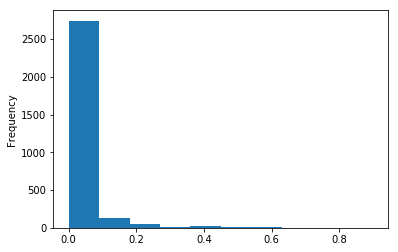

In [42]:
metrics.metric.plot.hist()

Find diff between directed to create a symmetric pairs.

In [74]:
# combinations - no duplicates.
from itertools import combinations

sym_metric_rows = []

for pair in combinations(countries, 2):
    countryA, countryB = pair
    if not countryA in metrics['countryA_alpha2'].unique():
        continue
    if not countryB in metrics['countryA_alpha2'].unique():
        continue
    print(countryA, countryB)
    metric_AB = metrics[
        (metrics['countryA_alpha2']==countryA) &
        (metrics['countryB_alpha2']==countryB)
    ]['metric'].values[0]
    metric_BA = metrics[
        (metrics['countryA_alpha2']==countryB) &
        (metrics['countryB_alpha2']==countryA)
    ]['metric'].values[0]
    diff = abs(metric_AB - metric_BA)
    sym_metric_rows.append([
        countryA,
        countryB,
        diff,
        countries[countryA],
        countries[countryB],
    ])
sym_metric = pd.DataFrame(sym_metric_rows, columns=[
    'countryA_alpha2',
    'countryB_alpha2',
    'diff',
    'countryA_alpha3',
    'countryB_alpha3',
])

AD AU
AD AT
AD BE
AD BG
AD BZ
AD BR
AD CA
AD CL
AD CN
AD CO
AD CR
AD CZ
AD DK
AD DZ
AD ES
AD FI
AD FR
AD GR
AD HK
AD HU
AD ID
AD IN
AD IS
AD IL
AD JP
AD KE
AD KR
AD LI
AD LT
AD LU
AD MD
AD MX
AD MY
AD NL
AD NO
AD NZ
AD PE
AD PL
AD PT
AD RO
AD RU
AD SA
AD SG
AD RS
AD SK
AD SE
AD SC
AD TR
AD TW
AD UA
AD US
AD VE
AD VN
AD ZA
AU AT
AU BE
AU BG
AU BZ
AU BR
AU CA
AU CL
AU CN
AU CO
AU CR
AU CZ
AU DK
AU DZ
AU ES
AU FI
AU FR
AU GR
AU HK
AU HU
AU ID
AU IN
AU IS
AU IL
AU JP
AU KE
AU KR
AU LI
AU LT
AU LU
AU MD
AU MX
AU MY
AU NL
AU NO
AU NZ
AU PE
AU PL
AU PT
AU RO
AU RU
AU SA
AU SG
AU RS
AU SK
AU SE
AU SC
AU TR
AU TW
AU UA
AU US
AU VE
AU VN
AU ZA
AT BE
AT BG
AT BZ
AT BR
AT CA
AT CL
AT CN
AT CO
AT CR
AT CZ
AT DK
AT DZ
AT ES
AT FI
AT FR
AT GR
AT HK
AT HU
AT ID
AT IN
AT IS
AT IL
AT JP
AT KE
AT KR
AT LI
AT LT
AT LU
AT MD
AT MX
AT MY
AT NL
AT NO
AT NZ
AT PE
AT PL
AT PT
AT RO
AT RU
AT SA
AT SG
AT RS
AT SK
AT SE
AT SC
AT TR
AT TW
AT UA
AT US
AT VE
AT VN
AT ZA
BE BG
BE BZ
BE BR
BE CA
BE CL
BE CN
BE CO
BE C

PT SA
PT SG
PT RS
PT SK
PT SE
PT SC
PT TR
PT TW
PT UA
PT US
PT VE
PT VN
PT ZA
RO RU
RO SA
RO SG
RO RS
RO SK
RO SE
RO SC
RO TR
RO TW
RO UA
RO US
RO VE
RO VN
RO ZA
RU SA
RU SG
RU RS
RU SK
RU SE
RU SC
RU TR
RU TW
RU UA
RU US
RU VE
RU VN
RU ZA
SA SG
SA RS
SA SK
SA SE
SA SC
SA TR
SA TW
SA UA
SA US
SA VE
SA VN
SA ZA
SG RS
SG SK
SG SE
SG SC
SG TR
SG TW
SG UA
SG US
SG VE
SG VN
SG ZA
RS SK
RS SE
RS SC
RS TR
RS TW
RS UA
RS US
RS VE
RS VN
RS ZA
SK SE
SK SC
SK TR
SK TW
SK UA
SK US
SK VE
SK VN
SK ZA
SE SC
SE TR
SE TW
SE UA
SE US
SE VE
SE VN
SE ZA
SC TR
SC TW
SC UA
SC US
SC VE
SC VN
SC ZA
TR TW
TR UA
TR US
TR VE
TR VN
TR ZA
TW UA
TW US
TW VE
TW VN
TW ZA
UA US
UA VE
UA VN
UA ZA
US VE
US VN
US ZA
VE VN
VE ZA
VN ZA


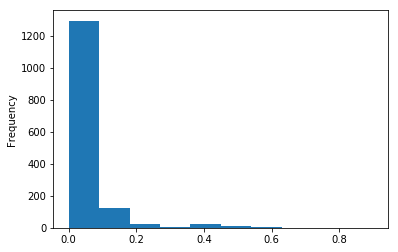

In [80]:
sym_metric['diff'].plot.hist()

Highest-diff symmetric pairs

In [82]:
sym_metric.sort_values(by='diff', ascending=False)

,countryA_alpha2,countryB_alpha2,diff,countryA_alpha3,countryB_alpha3
1130,KR,US,0.90,KOR,USA
1051,JP,KR,0.62,JPN,KOR
376,CA,KR,0.56,CAN,KOR
1111,KR,MX,0.52,KOR,MEX
677,DZ,KR,0.52,DZA,KOR
...,...,...,...,...,...
992,IS,KR,0.00,ISL,KOR
993,IS,LI,0.00,ISL,LIE
994,IS,LT,0.00,ISL,LTU
995,IS,LU,0.00,ISL,LUX


# Correlations

Correlate our metric to other dimensions of international relations

TODO:
- EU
- NATO